In [2]:
from main import getEdge
import argparse
from unittest import mock

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [179]:
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import os
from math import sqrt
from datetime import datetime
from datetime import timedelta
import matplotlib.dates as mdates
from scipy import stats

def canny_edge(in_filename):
    img = cv2.imread(in_filename,0)
    gray_filtered = cv2.bilateralFilter(img, 10, 500, 2)

    # Using the Canny filter to get contours
    edges = cv2.Canny(gray_filtered, 20, 30)
    # Using the Canny filter with different parameters
    edges_high_thresh = cv2.Canny(gray_filtered, 60, 120)
    # Stacking the images to print them together
    # For comparison
    images = np.hstack((img, edges, edges_high_thresh))
    # Output the resulting

    cv2.imwrite('images/canny_img/canny_'+ \
                 os.path.splitext(os.path.basename(in_filename))[0] + \
                 '.png',images)
    return edges_high_thresh

def contours_metadata(contours):
    ##將contours的metadata存入contours_data
    contours_data={}
    cnts_perimeter=[]
    cnts_area=[]
    cnts_index=[]

    ## 計算資料分布改框的條件，因為小於200的資料太多，故刪除
    for c in contours:
        if cv2.contourArea(c)>200.0 and \
           cv2.arcLength(c,False)<600 :
            cnts_index.append(c)
            cnts_perimeter.append(cv2.arcLength(c,False))
            cnts_area.append(cv2.contourArea(c))
    contours_data['index']=cnts_index
    contours_data['perimeter']=cnts_perimeter
    contours_data['area']=cnts_area
    # show_statistic(contours_data['area'],25.0)

    # plt.hist(contours_data['area'], color = 'blue', edgecolor = 'black'
    #          ,bins = int((max(contours_data['area'])-min(contours_data['area']))/25.0))
    contours_data['area_avg']=np.average(contours_data['area'])
    contours_data['area_variance']=np.var(contours_data['area'])
    contours_data['area_std']=np.std(contours_data['area'])
    bp_dict=plt.boxplot(contours_data['area'])

    contours_data['area_Q1']=[item.get_ydata()[1] for item in bp_dict['boxes']][0]
    contours_data['area_Q3']=[item.get_ydata()[3] for item in bp_dict['boxes']][0]
    contours_data['area_median']=[item.get_ydata()[1] for item in bp_dict['medians']][0]
    contours_data['area_min']=[item.get_ydata()[1] for item in bp_dict['whiskers']][0]
    contours_data['area_max']=[item.get_ydata()[1] for item in bp_dict['whiskers']][1]

    plt.clf()
    plt.close()
    # print("25%: ",contours_data['area_Q1'])
    # print("75%: ",contours_data['area_Q3'])
    # print("median: ",contours_data['area_median'])
    # print("min",contours_data['area_min'])
    # print("max",contours_data['area_max'])

    return contours_data


def myfunc(x):
    return slope * x + intercept

#x, y: data to fit
#pyplot_formatter: pyplot Format Strings
#fit_type: one of "exp", "poly", "linear"
# "poly" will use 3rd degree polynomial to draw the fit curve

def draw_fitline(ax, x, y, pyplot_formatter, fit_type):
    
    def R2(x, y, coefs):
        p = np.poly1d(coefs)
        yhat = p(x) # or [p(z) for z in x]
        ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
        ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
        sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
        return ssreg / sstot
    
    order = 3
    dot_num = 100
    x_base = x[0]
    x = [item - x_base for item in x]
    xp = np.linspace(x[0], x[-1], dot_num)
    
    main_ax = ax.twiny()
    original_xlim = ax.get_xlim()
    main_ax.set_xlim([timestamp - x_base for timestamp in original_xlim])

    
    if fit_type == "exp":
             
        # Using polyfit to compute exponential regression function
        # y = b*exp(a*x)
        exp_coef = np.polyfit(x, np.log(y), 1)
        pexp = np.poly1d(exp_coef)
        
        # But be careful, to transform a linear function to a exponential function
        # we should addjust coefficients.
        print(exp_coef)
        a = exp_coef[0]
        b = np.exp(exp_coef[1])
        
        print("R2 value: ")
        print(R2(x, np.log(y), exp_coef))
        print("for function y = b*exp(a*x), b = {b:e}, a={a:e}".format(b=b, a=a))
        line_expfit, = main_ax.plot(xp, np.exp(pexp(xp)), label=r'exponential regression $y = {b:.2f}e^{{{a:.2f}x}}$'.format(b=b, a=a))
        main_ax.legend(handles=[line_expfit])
        
        return line_expfit
        
        
    elif fit_type == "linear":
        slope, intercept, r, p, std_err = stats.linregress(x, y)
        y_regression = [slope * n + intercept for n in x]
        
        print("R2 value: ")
        print(R2(x, y, [slope, intercept]))
        print("for function y = a*x + b, a = {a}, b = {b}".format(a=slope, b=intercept))
        
        line_regression, = main_ax.plot(x, y_regression, label=r'linear regression $y = {a:.2f}x + {b:.2f}$'.format(a=slope, b=intercept))
        main_ax.legend(handles=[line_regression])

        return line_regression
        
    elif fit_type == "poly":
        poly_coef = np.polyfit(x, y, order)
        p3 = np.poly1d(poly_coef)
        
        print("R2 value: ")
        print(R2(x, y, poly_coef))
        print("for function y = ax^3 + bx^2 + cx + d, \n a = {a}, \n b = {b}, \n c = {c}, \n d = {d}".format(
            a=poly_coef[3], 
            b=poly_coef[2],
            c=poly_coef[1],
            d=poly_coef[0]))
        
        line_regression, = main_ax.plot(xp, p3(xp), label=r'polynomial regression $y = {a:.2f}x^3 + {b:.2f}x^2 + {c:.2f}x + {d:.2f}$'.format(
            a=poly_coef[3], 
            b=poly_coef[2],
            c=poly_coef[1],
            d=poly_coef[0]))
        main_ax.legend(handles=[line_regression])
        
        return line_regression
        

def BudContours():
    directory="images/edged_img/"
    datetime_objects=[]
    files=[]
    banana_volume_list=[]
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # files.append(os.path.join(directory,filename))
            # name, file_extension = os.path.splitext(filename)
            # last_underscore_index = name.rfind('_')
            # date_info = name[0:last_underscore_index]
            # banana_seq = int(name[-1])
            datetime_objects.append(datetime.strptime(filename,"image_%d-%m-%Y_%I-%M-%S_%p.png"))
            # datetime_objects.append(datetime.strptime(date_info,"%m_%d_%H_%M_%S"))
            # print("--",os.path.join(directory,filename))

    datetime_objects=sorted(datetime_objects)
    for d in datetime_objects:
        filename=d.strftime("image_%d-%m-%Y_%I-%M-%S_%p.png")
        files.append(os.path.join(directory,filename))
        # print("--",os.path.join(directory,filename))

    for f in files:
        edges = canny_edge(f)
        ret,thresh = cv2.threshold(edges,127,255,0)
        # img = cv2.imread(f,0)
        #ret,thresh = cv2.threshold(img,127,255,0)
        # blurred = cv2.GaussianBlur(img, (5, 5), 0)
        # value, thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY_INV)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        metadata = contours_metadata(contours)
        minimum =metadata['area_min']
        median =metadata['area_median']
        maximum =metadata['area_max']
        area_avg = metadata['area_avg']
        area_std = metadata['area_std']
        q1=metadata['area_Q1']
        cnt_with_area =[]
        total_area = 0.0
        total_volume = 0.0
        # /** 針對average、standard deviation去篩選contours */
        for c in contours:
            #if cv2.contourArea(c)>(minimum)and \
             #cv2.contourArea(c)<(maximum):
            cnt_with_area.append(c)
            a = cv2.contourArea(c)
            total_area += a
            total_volume += sqrt(a)**3
        # print(len(cnt_with_area))

        # /** 使用Q1、medina、Q3來篩選contours
        # for c in contours:
        #     if cv2.contourArea(c)> median and \
        #         cv2.contourArea(c)< maximum :
        #         cnt_with_area.append(c)
        #         total_area += cv2.contourArea(c)

        read_filename = directory+ \
                        os.path.splitext(os.path.basename(f))[0] +\
                    '.png'
        print(read_filename)
        out_filename = 'images/result_pics/res_' + os.path.splitext(os.path.basename(f))[0] + '.png'
        result = cv2.drawContours(cv2.imread(read_filename), cnt_with_area, -1, (0,0,255), 2)
        cv2.imwrite(out_filename, result)
        ## 畫圖
        # if len(cnt_with_area)!=0.0:
        # print(total_area)
        # print(cnt_with_area)
        avg_area = total_area / len(cnt_with_area)

        banana_volume = sqrt(avg_area)**3
        avg_volume = total_volume / len(cnt_with_area)
        # banana_volume_list.append(banana_volume)
        # banana_volume_list.append(avg_volume)
        # banana_volume_list.append(total_volume)
        # banana_volume_list.append(total_area)
        banana_volume_list.append(avg_area)
    x = list(range(1, len(banana_volume_list)+1))
    x = np.array([ i.toordinal() for i in datetime_objects ])
    y_dots = np.array(banana_volume_list)
    for co in range(len(y_dots)):
        if y_dots[co] > 10000.0:
            y_dots = filterData(co , y_dots)
    ###filter array
    #if you don't want data be filtered
    #you can always comment these lines
    filter_array = y_dots > 0  #y_dots > 0 equals to return np.where(y_dots!=0)
    x = x[filter_array]
    y_dots = y_dots[filter_array]       #y_dots[np.where(y_dots != 0)]
    ###filter array end
    ax = plt.gca()
    formatter = mdates.DateFormatter("%b")
    ax.xaxis.set_major_formatter(formatter)

    locator = mdates.MonthLocator()
    ax.xaxis.set_major_locator(locator)

    formatter = mdates.DateFormatter("%d")
    ax.xaxis.set_minor_formatter(formatter)

    locator = mdates.DayLocator()
    ax.xaxis.set_minor_locator(locator)

    left_range = min(datetime_objects) - timedelta(days=1)
    right_range = max(datetime_objects) + timedelta(days=1)

    # ax.set_xlim([datetime(2020, 6, 10), datetime(2020, 7, 1)])
    ax.set_xlim([left_range, right_range])

    ax.scatter(x, y_dots)

    draw_fitline(ax, x, y_dots, '-', 'exp')

    plt.savefig("scatter.png")

    plt.show()
    
    return x, y_dots

def filterData(x, y_dots): #filter insuitable data and replace with 0
    temp = 0
    c = len(y_dots) - x #left how much to go
    temp = x
    i = 0;
    while  i < c:
        if y_dots[temp] < (y_dots[temp-1] - 9000.0):
            y_dots[temp] = 0
            i += 1
            temp += 1
        else:
            temp += 1
            i += 1
    return y_dots

images/edged_img/image_03-07-2020_01-00-21_AM.png
images/edged_img/image_04-07-2020_01-00-24_AM.png
images/edged_img/image_04-07-2020_01-00-54_PM.png
images/edged_img/image_05-07-2020_01-00-55_AM.png
images/edged_img/image_05-07-2020_01-01-55_AM.png
images/edged_img/image_06-07-2020_01-00-40_AM.png
images/edged_img/image_06-07-2020_01-00-11_PM.png
images/edged_img/image_07-07-2020_01-00-17_AM.png
images/edged_img/image_07-07-2020_01-00-32_PM.png
images/edged_img/image_08-07-2020_01-00-55_AM.png
images/edged_img/image_08-07-2020_01-00-40_PM.png
images/edged_img/image_09-07-2020_01-00-10_AM.png
images/edged_img/image_09-07-2020_01-00-22_PM.png
images/edged_img/image_10-07-2020_01-00-58_AM.png
images/edged_img/image_10-07-2020_01-00-23_PM.png
images/edged_img/image_11-07-2020_01-00-02_AM.png


c:\users\ccres\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\ccres\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\ccres\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3506: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
c:\users\ccres\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
c:\users\ccres\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\ccres\appdata\local\programs\python\python37\lib\

images/edged_img/image_11-07-2020_01-00-25_PM.png
[0.28484856 7.4864597 ]
R2 value: 
0.982358319298386
for function y = b*exp(a*x), b = 1.783726e+03, a=2.848486e-01


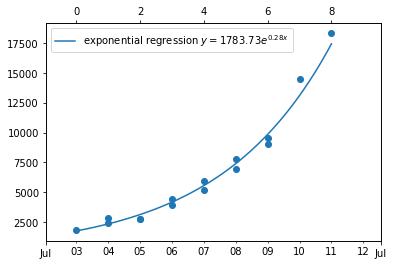

In [180]:
out = BudContours()


In [141]:
x, y = out

In [162]:
x

array([737609, 737610, 737610, 737611, 737611, 737612, 737612, 737613,
       737613, 737614, 737614, 737615, 737615, 737616, 737617])

[ 2.84848556e-01 -2.10099372e+05]
R2 value: 
0.982358319227697
for function y = b*exp(a*x), b = 0.0, a=0.28484855625484995


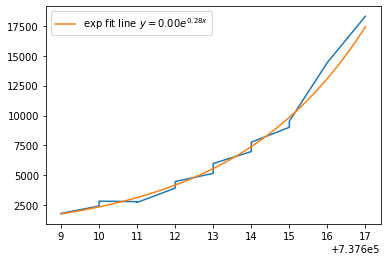

In [145]:

dot_num = 100
xp = np.linspace(x[0], x[-1], dot_num)
#x = np.linspace(1, len(y), len(y))
exp_coef = np.polyfit(x, np.log(y), 1)
pexp = np.poly1d(exp_coef)

plt.plot(x, y)

# But be careful, to transform a linear function to a exponential function
# we should addjust coefficients.
print(exp_coef)
a = exp_coef[0]
b = np.exp(exp_coef[1])

print("R2 value: ")
print(R2(x, np.log(y), exp_coef))
print("for function y = b*exp(a*x), b = {b}, a={a}".format(b=b, a=a))
line_expfit, = plt.plot(xp, np.exp(pexp(xp)), label=r'exp fit line $y = {b:.2f}e^{{{a:.2f}x}}$'.format(b=b, a=a))
plt.legend(handles=[line_expfit])


$$ln(y) = 0.15x + 7.36$$
$$e^{ln(y)} = e^{0.15x + 7.36}$$
$$y = e^{7.36} \times e^{0.15x}$$
$$y = e^b \times e^{ax}$$
$y = be^{ax}$

In [86]:
# ax+b to 
# b*exp(a*x)
def f(x, a, b):
    return np.exp(b + a * x)

def R2(x, y, coefs):
    p = np.poly1d(coefs)
    yhat = p(x) # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    return ssreg / sstot

In [107]:
a = exp_coef[0]
b = np.exp(exp_coef[1])

R2 value: 
0.975116485764993
for function y = b*exp(a*x), b = 1583.6942335715396, a=0.15017108687423095


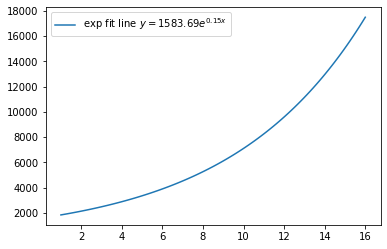

In [111]:
print("R2 value: ")
print(R2(x, np.log(y), exp_coef))
print("for function y = b*exp(a*x), b = {b}, a={a}".format(b=b, a=a))
line_expfit, = plt.plot(xp, f(xp, exp_coef[0], exp_coef[1]), label=r'exp fit line $y = {b:.2f}e^{{{a:.2f}x}}$'.format(b=b, a=a))
plt.legend(handles=[line_expfit])

In [90]:
np.exp(exp_coef[0])

1.1620330343220773

c:\users\ccres\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


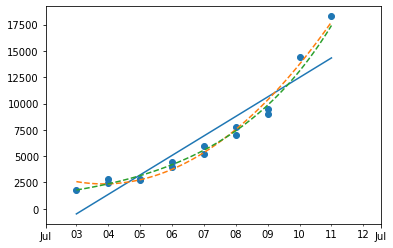

In [92]:
def myfunc(x):
    return slope * x + intercept

x = np.array([ i.toordinal() for i in datetime_objects ])
y_dots = np.array(y_dots)

filter_array = y_dots > 1000

x = x[filter_array]
y_dots = y_dots[filter_array]

slope, intercept, r, p, std_err = stats.linregress(x, y_dots)
y_regression = list(map(myfunc, x))


#x = list(range(1, len(y_dots)+1))


ax = plt.gca()
formatter = mdates.DateFormatter("%b")
ax.xaxis.set_major_formatter(formatter)

locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(locator)

formatter = mdates.DateFormatter("%d")
ax.xaxis.set_minor_formatter(formatter)

locator = mdates.DayLocator()
ax.xaxis.set_minor_locator(locator)

left_range = min(datetime_objects) - timedelta(days=1)
right_range = max(datetime_objects) + timedelta(days=1)

# ax.set_xlim([datetime(2020, 6, 10), datetime(2020, 7, 1)])
ax.set_xlim([left_range, right_range])

ax.scatter(x, y_dots)
ax.plot(x, y_regression)



plt.savefig("scatter.png")

plt.show()